# **0. Setup**

## 0.1. Library and Environment

In [ ]:
!pip -U install pandas matplotlib yfinance seaborn plotly alpha_vantage python-dotenv nbformat statsmodels

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from dotenv import load_dotenv
from alpha_vantage.timeseries import TimeSeries
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"

load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY_2")
print(ALPHA_VANTAGE_API_KEY)

A1AHKBYRATJ0YIKH


## 0.2. Data Loading

In [2]:
raw_data = yf.download(
    tickers = "^SP500-40",
    start = "1900-01-01",
    end = "2025-01-01",
    interval = "1D",
    progress=False,
    auto_adjust=True
)

raw_data.columns = raw_data.columns.get_level_values(0)
raw_data = raw_data[['Open', 'High', 'Low', 'Close', 'Volume']]
raw_data.reset_index(inplace=True)
raw_data.columns.name = None
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

## 0.3. Data Augmentation

### 0.3.1. Economic Index

In [3]:
alias = {
    "VIXY": "VIX",
    "IEF": "US10Y",
    "UUP": "DXY",
    "USO": "OIL",
    "GLD": "GOLD",
    "CPI": "CPI_US"
}

def get_indicator(symbol, start, end):
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    data, meta = ts.get_daily(symbol=symbol, outputsize='full')

    data = data.rename(columns={'4. close': 'Close'})
    data.index = pd.to_datetime(data.index)
    data = data.loc[(data.index >= start) & (data.index <= end)]

    data = data.reset_index()
    if 'index' in data.columns:
        data = data.rename(columns={'index': 'Date'})
    elif 'date' in data.columns:
        data = data.rename(columns={'date': 'Date'})
    else:
        data['Date'] = data.index

    clean_name = alias.get(symbol, re.sub(r'[^A-Za-z0-9_]+', '', symbol))
    data = data.rename(columns={'Close': clean_name})

    return data[['Date', clean_name]].dropna()

start_date = raw_data['Date'].min().strftime('%Y-%m-%d')
end_date   = raw_data['Date'].max().strftime('%Y-%m-%d')

symbols = ["VIXY", "IEF", "UUP", "USO", "GLD", "CPI"]

aug_data = raw_data.copy()
for sym in symbols:
    try:
        ind = get_indicator(sym, start_date, end_date)
        aug_data = pd.merge_asof(
            aug_data.sort_values('Date'),
            ind.sort_values('Date'),
            on='Date'
        )
        print(f"Merged {sym}")
    except Exception as e:
        print(f"Error when fetch {sym}: {e}")

Merged VIXY
Merged IEF
Merged UUP
Merged USO
Merged GLD
Merged CPI


### 0.3.2. Financial Indicators

In [4]:
delta = aug_data['Close'].diff()
abs_diff = delta.abs()

# MA, EMA
for w in [20, 60, 120]:
    aug_data[f'MA_{w}'] = aug_data['Close'].rolling(window=w).mean()
    aug_data[f'EMA_{w}'] = aug_data['Close'].ewm(span=w, adjust=False).mean()

# MAE
for w in [5, 20]:
    aug_data[f'MAE_{w}'] = abs_diff.rolling(window=w).mean()


# MACD
ema12 = aug_data['Close'].ewm(span=12, adjust=False).mean()
ema26 = aug_data['Close'].ewm(span=26, adjust=False).mean()
ema60 = aug_data['Close'].ewm(span=60, adjust=False).mean()
ema120 = aug_data['Close'].ewm(span=120, adjust=False).mean()

aug_data['MACD'] = ema12 - ema26
aug_data['MACD_long'] = ema60 - ema120
aug_data['Signal'] = aug_data['MACD'].ewm(span=9, adjust=False).mean()
aug_data['Signal_long'] = aug_data['MACD_long'].ewm(span=45, adjust=False).mean()

# RSI
delta = aug_data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
aug_data['RSI'] = 100 - (100 / (1 + rs))

for p in [7, 14, 28]:
    avg_gain = gain.rolling(p).mean()
    avg_loss = loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    aug_data[f'RSI_{p}'] = 100 - (100 / (1 + rs))

# **1. EDA**

## 1.1. Data Summary

In [ ]:
aug_data.info()

In [ ]:
aug_data.describe()

## 1.2. Preprocessing

In [ ]:
print(f"Null value check: \n{aug_data.isna().sum()}")

In [ ]:
duplicate_count = aug_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

In [5]:
first_valid_index = aug_data.dropna().index.min()
cropped_data = aug_data.loc[first_valid_index:].reset_index(drop=True)
print("\nNew shape:", cropped_data.shape)


New shape: (3518, 28)


## 1.3. Statistical Analysis

In [6]:
data = cropped_data.copy()

def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include=['number']).columns
})
stats_summary

,Open,High,Low,Close,Volume,VIX,US10Y,DXY,OIL,GOLD,CPI_US,MA_20,EMA_20,MA_60,EMA_60,MA_120,EMA_120,MAE_5,MAE_20,MACD,MACD_long,Signal,Signal_long,RSI,RSI_7,RSI_14,RSI_28
mean,416.459915,419.610855,413.316316,416.580211,1.197605e+08,25.289144,105.360025,25.017769,35.072762,148.542763,26.580698,414.966987,414.952079,411.458288,411.563439,406.576574,406.889095,3.731170,3.721269,1.215616,4.674345,1.221636,4.497438,54.383979,54.519207,54.383979,54.048229
median,406.690002,410.020004,403.309998,406.745010,4.748800e+06,20.470000,105.330000,25.060000,33.615000,143.880000,26.592500,405.914249,406.050263,403.902667,404.316265,401.433917,406.148377,2.930005,3.040243,1.486598,4.074653,1.466118,4.068069,54.428400,54.871884,54.428400,54.347001
std,156.521521,157.565916,155.479851,156.526060,1.629818e+08,17.136061,7.295446,2.383741,22.894994,31.642322,0.872154,155.198624,155.028135,152.335559,152.175074,148.997245,148.740057,2.980491,2.481358,6.036312,11.229062,5.651588,10.349887,16.284104,22.755735,16.284104,11.289183
min,151.729996,158.000000,147.660004,153.899994,0.000000e+00,5.250000,88.950000,20.930000,2.130000,100.500000,23.919900,162.902000,163.194174,169.174833,172.083540,172.688666,177.768672,0.262006,0.619501,-47.619195,-31.174432,-41.028616,-25.386829,2.186875,0.000000,2.186875,21.404229
max,854.250000,857.109985,851.289978,851.979980,1.335046e+09,121.950000,123.060000,30.670000,91.990000,257.500000,28.520000,835.313501,830.505641,806.952665,802.998564,769.021499,774.446570,37.620001,24.299998,18.004074,36.935660,16.728409,34.841029,96.628614,100.000000,96.628614,85.733906
q1,297.874992,299.687508,295.830002,297.967506,0.000000e+00,14.050000,101.270000,22.710000,12.740000,121.332500,25.890000,297.001375,296.699491,295.947127,296.945605,296.267418,296.460104,1.850499,2.053999,-1.243367,-0.311478,-0.960669,-0.745924,43.065670,37.601945,43.065670,46.147471
q3,537.517517,543.132507,533.512482,537.649994,2.544945e+08,29.545000,109.300000,26.470000,47.795000,169.505000,27.344850,539.542501,540.549710,546.192373,546.998772,548.107376,552.929139,4.656497,4.767378,4.166297,9.681235,3.857002,9.171006,66.224710,71.842171,66.224710,62.215228
iqr,239.642525,243.445000,237.682480,239.682487,2.544945e+08,15.495000,8.030000,3.760000,35.055000,48.172500,1.454850,242.541126,243.850219,250.245247,250.053167,251.839958,256.469035,2.805998,2.713379,5.409664,9.992713,4.817672,9.916930,23.159041,34.240226,23.159041,16.067757


In [ ]:
data.describe(include=['number'])

## 1.4. Visualization

### 1.4.1. Candlestick Chart
Candlestick charts are a classic tool in financial analysis, helping to easily identify trends, fluctuations and market sentiment in each session.


In [7]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data['Date'],
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=0.4
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='S&P 500 Financials (Sector) (^SP500-40)',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Index',
    xaxis_rangeslider_visible=False,
    template='seaborn',
    width=2000,
    height=600,
)

fig.show()

### 1.4.2. Boxplot

Boxplots help detect outlier data, an important step in EDA to ensure that the subsequent analysis model is not affected by unusual values.

/tmp/ipykernel_700464/635962949.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_700464/635962949.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_700464/635962949.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_700464/635962949.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_700464/635962949.py:17: FutureWarning:



Passing `palette` without assigning `hue` is de

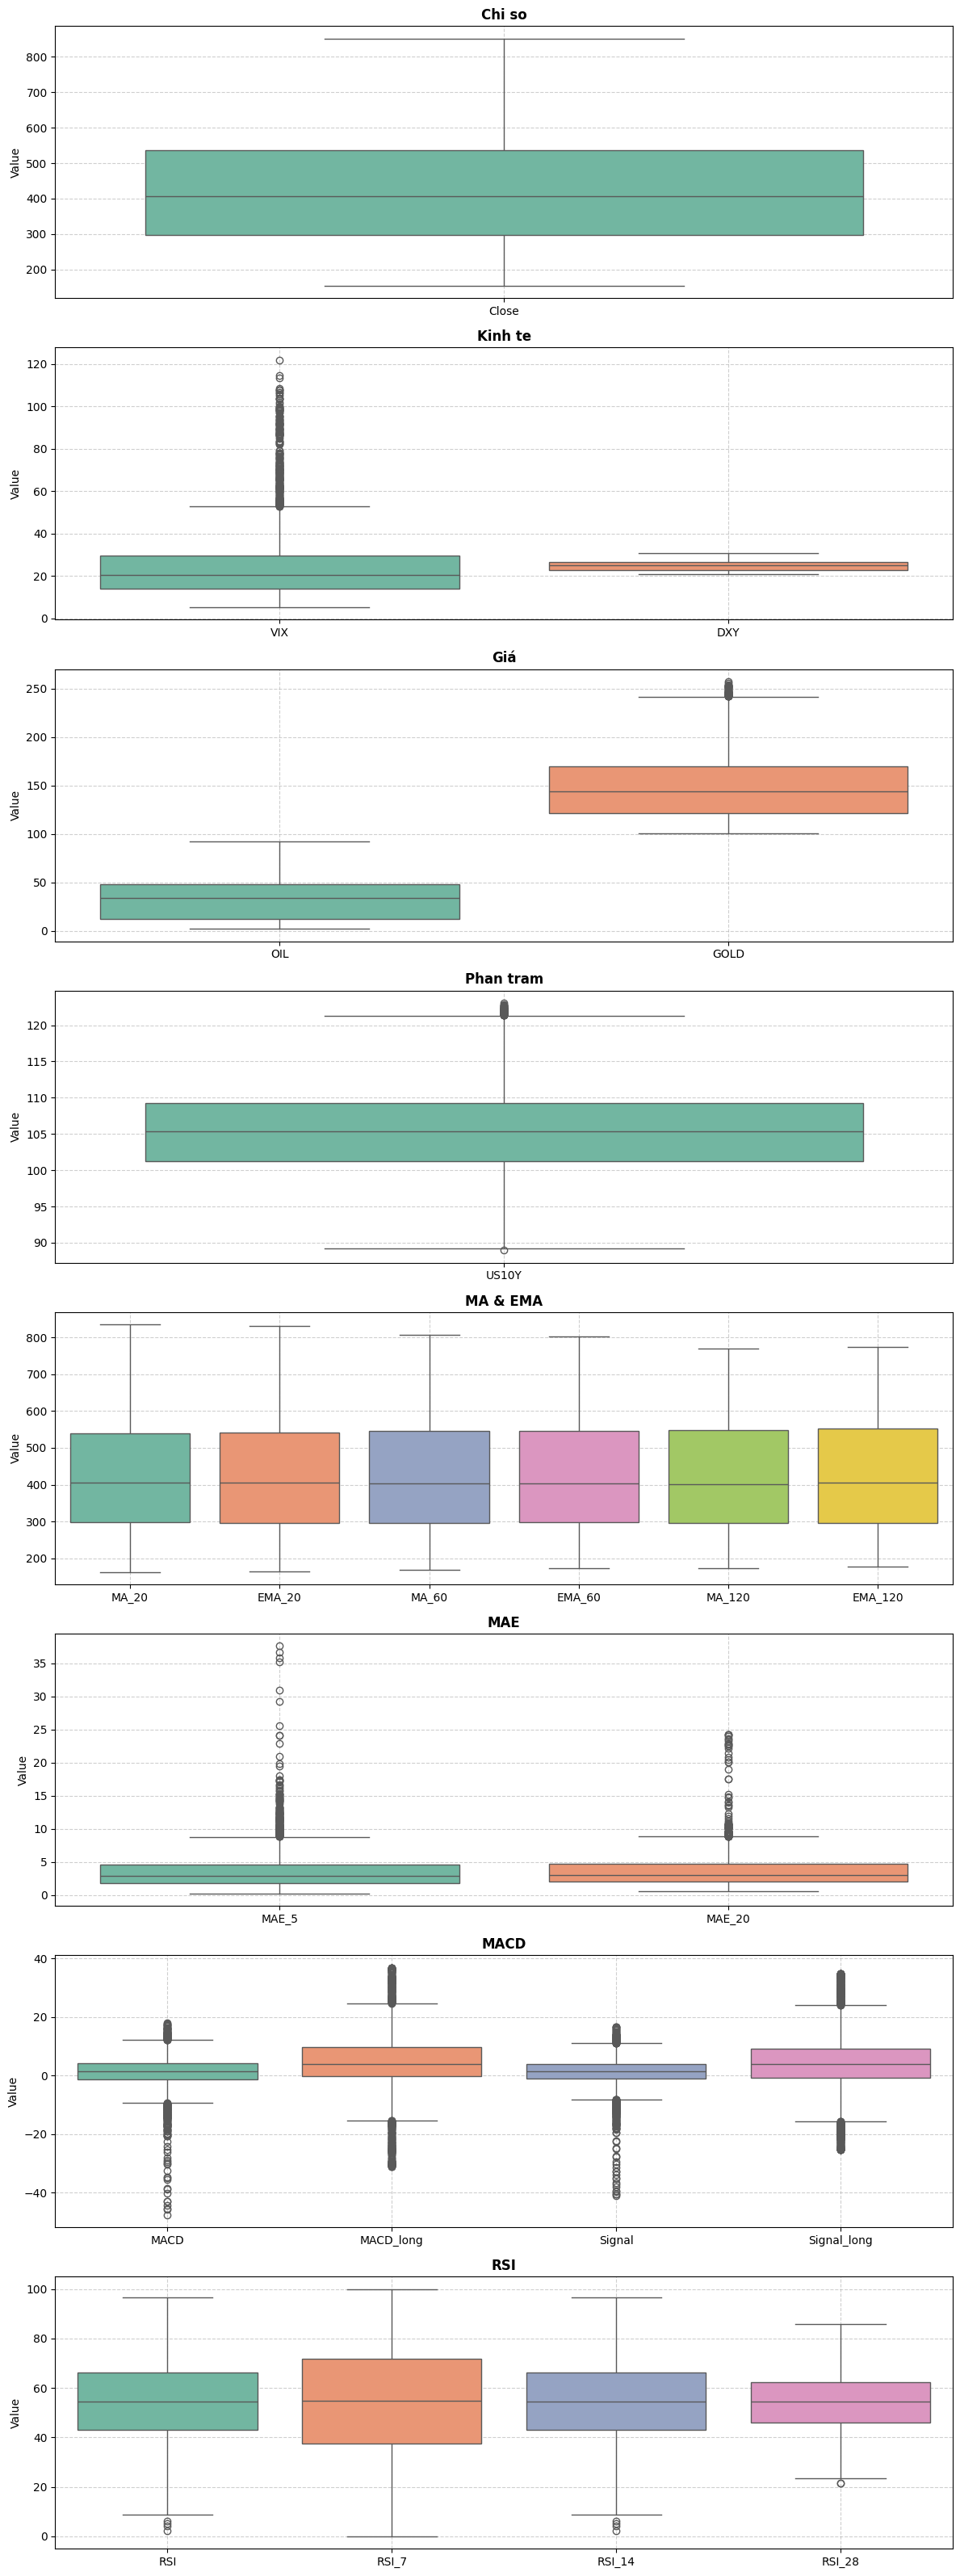

In [8]:
groups = {
    "Chi so": ['Close'],
    'Kinh te': [ 'VIX', 'DXY'],
    "Giá": ['OIL', 'GOLD'],
    "Phan tram": ['US10Y'],
    "MA & EMA": ['MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120'],
    "MAE": ['MAE_5', 'MAE_20'],
    "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    "RSI": ['RSI', 'RSI_7', 'RSI_14', 'RSI_28']
}

fig, axes = plt.subplots(len(groups), 1, figsize=(12, 4*len(groups)))

for ax, (title, cols_in_group) in zip(axes, groups.items()):
    data_melted = data.melt(value_vars=cols_in_group,
                            var_name="Value Type", value_name="Value")
    sns.boxplot(x="Value Type", y="Value", data=data_melted,
                ax=ax, palette="Set2", order=cols_in_group)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "boxplot_grouped.png"), dpi=150)
plt.show()
plt.close()

### 1.4.3. Histogram

Histogram is the basic chart to identify the distribution of data.

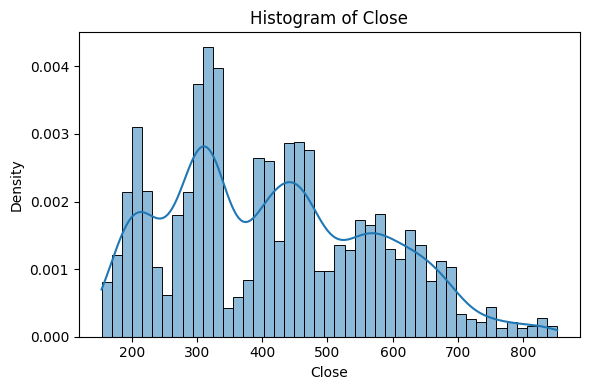

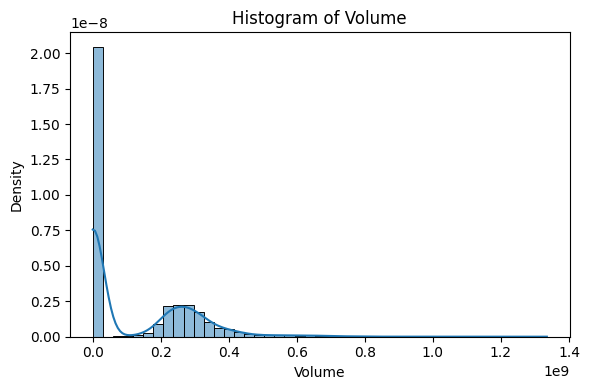

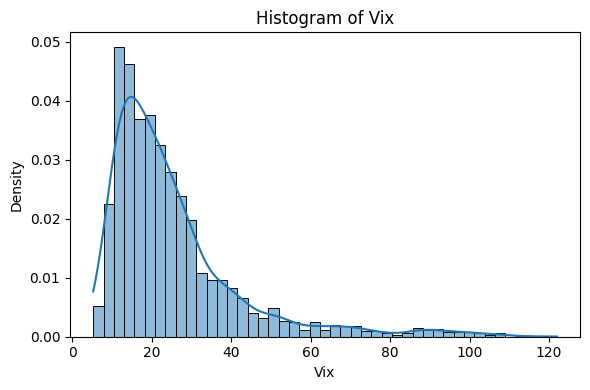

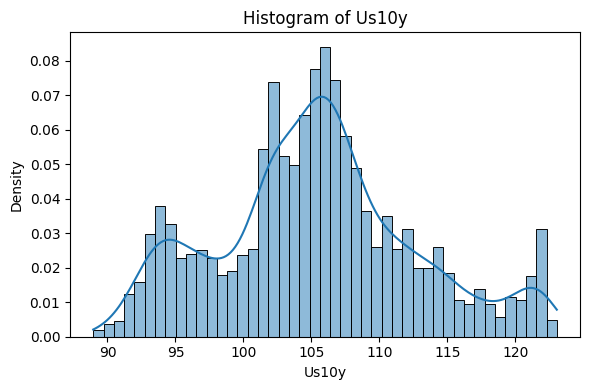

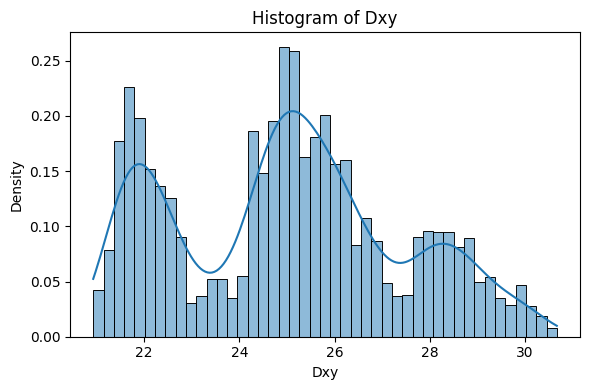

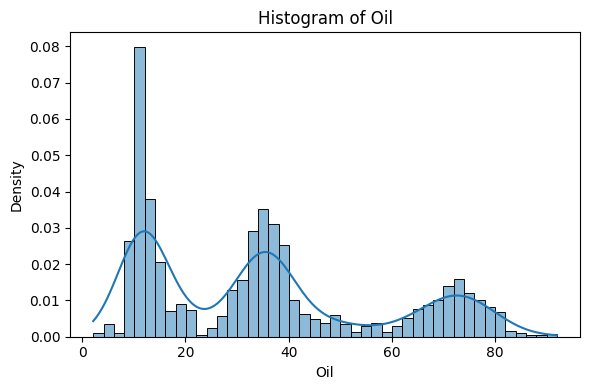

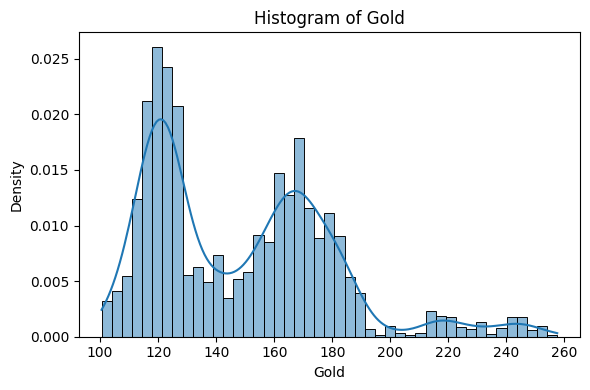

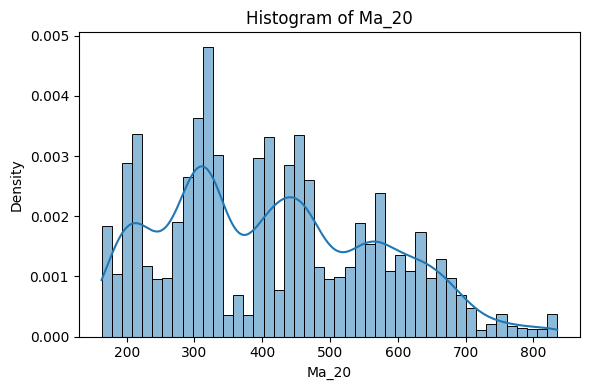

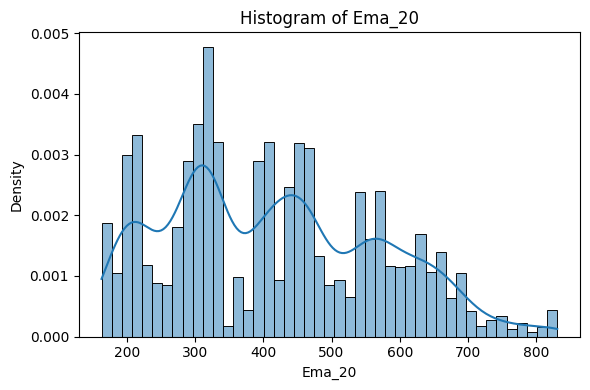

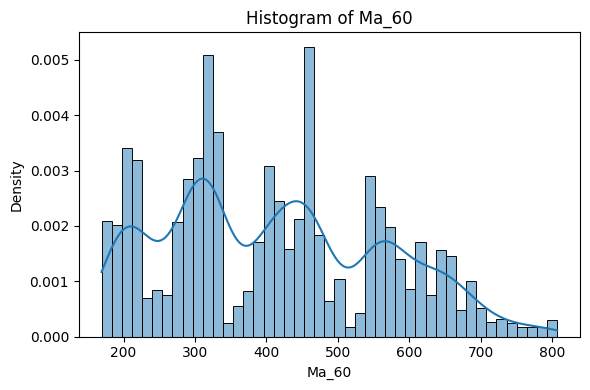

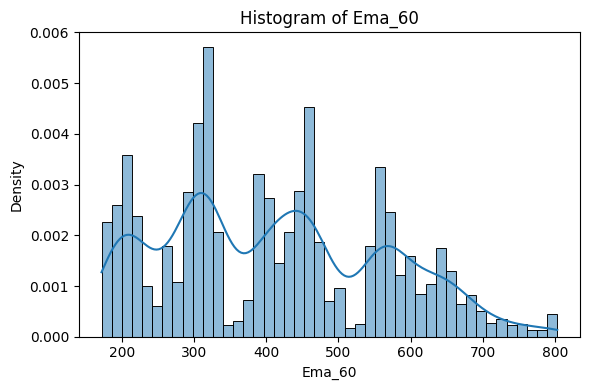

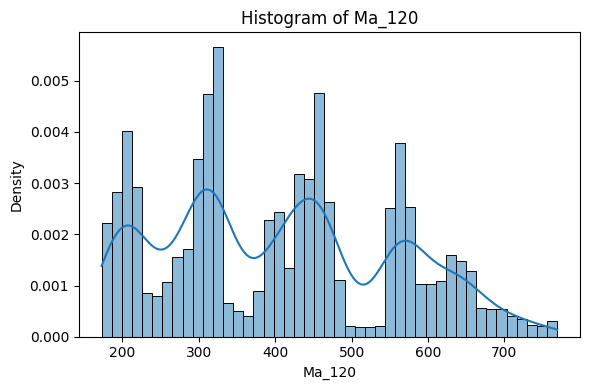

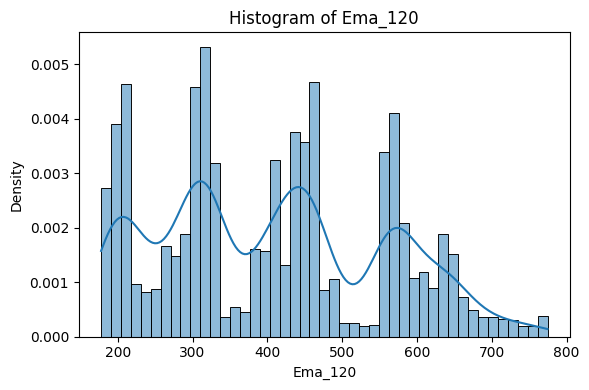

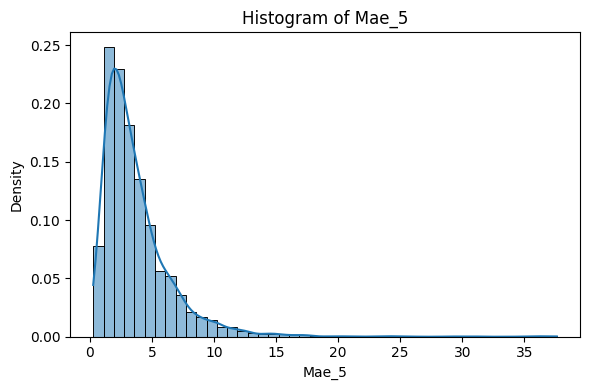

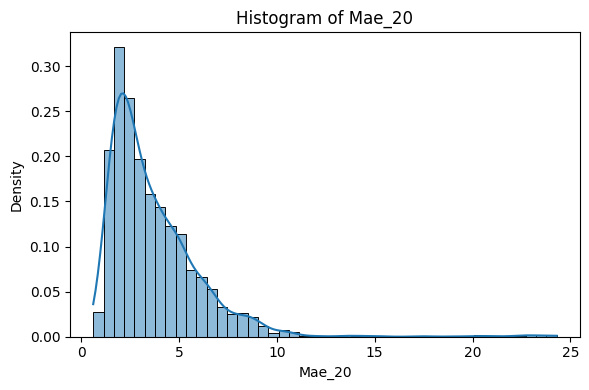

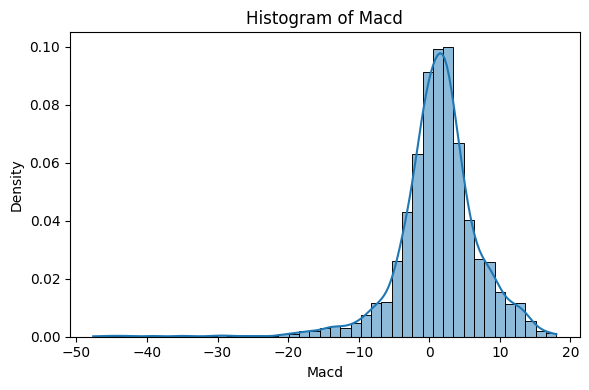

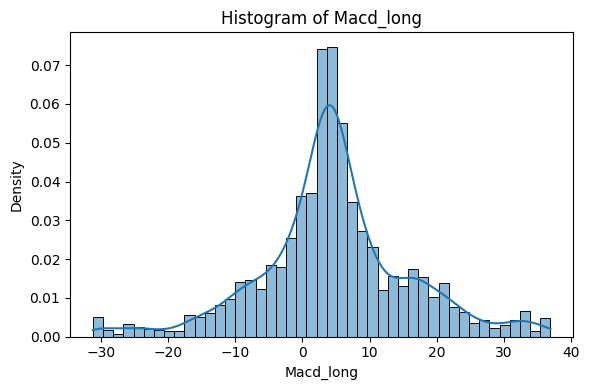

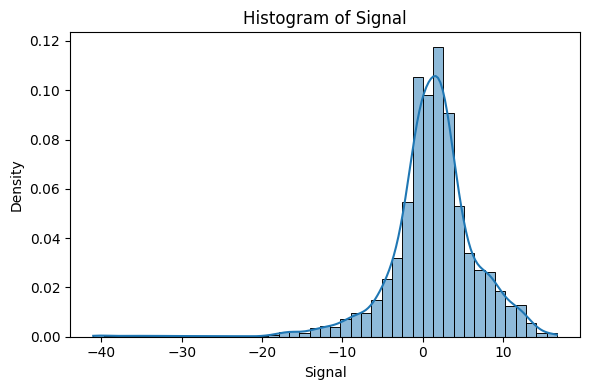

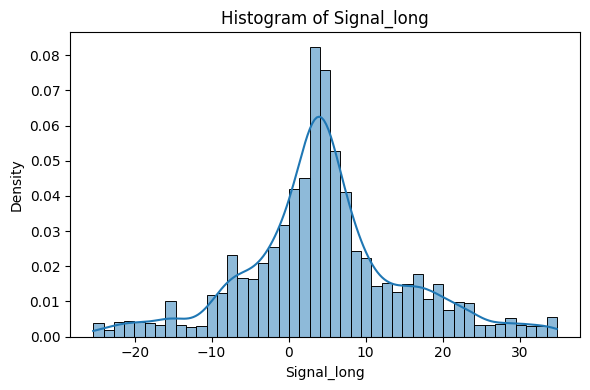

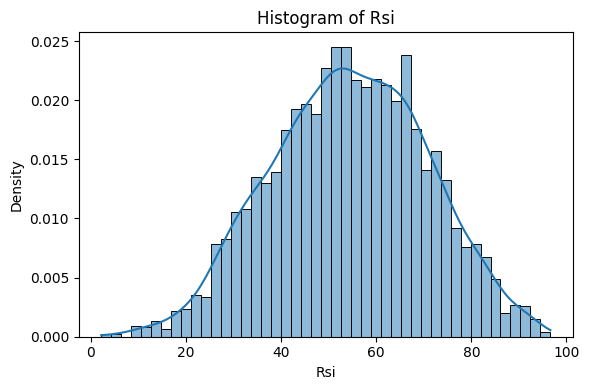

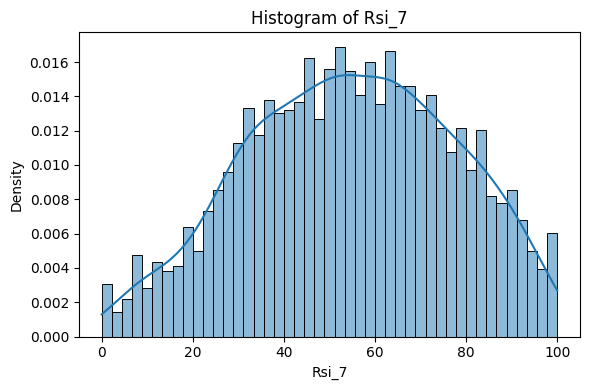

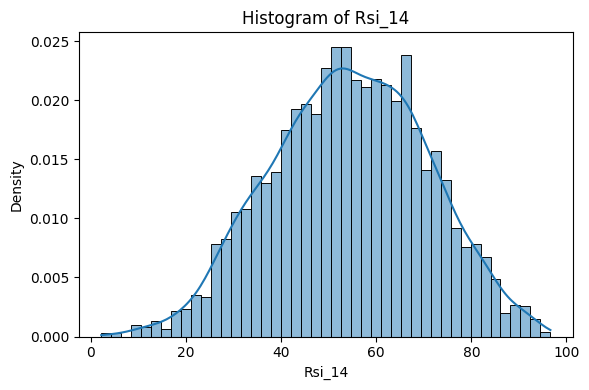

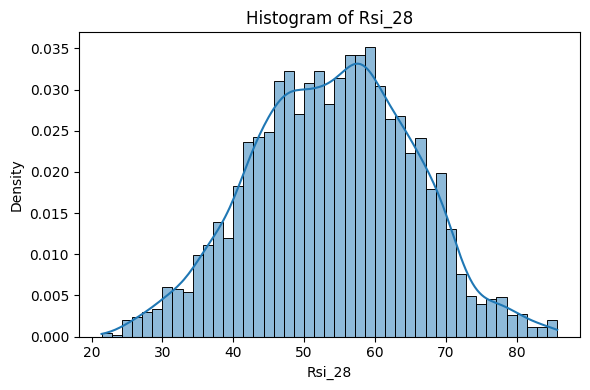

In [9]:
cols = ['Close', 'Volume', 'VIX', 'US10Y', 'DXY',
       'OIL', 'GOLD', 'MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120',
       'EMA_120', 'MAE_5', 'MAE_20', 'MACD', 'MACD_long', 'Signal',
       'Signal_long', 'RSI', 'RSI_7', 'RSI_14', 'RSI_28']

for col in cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col].dropna(), kde=True, stat="density", bins=45)
    plt.title(f"Histogram of {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Density")
    plt.tight_layout()

    hist_path = os.path.join(FIG_DIR, f"hist_{col}.png")
    plt.savefig(hist_path, dpi=150)
    plt.show()
    plt.close()


### 1.4.4. Line Chart

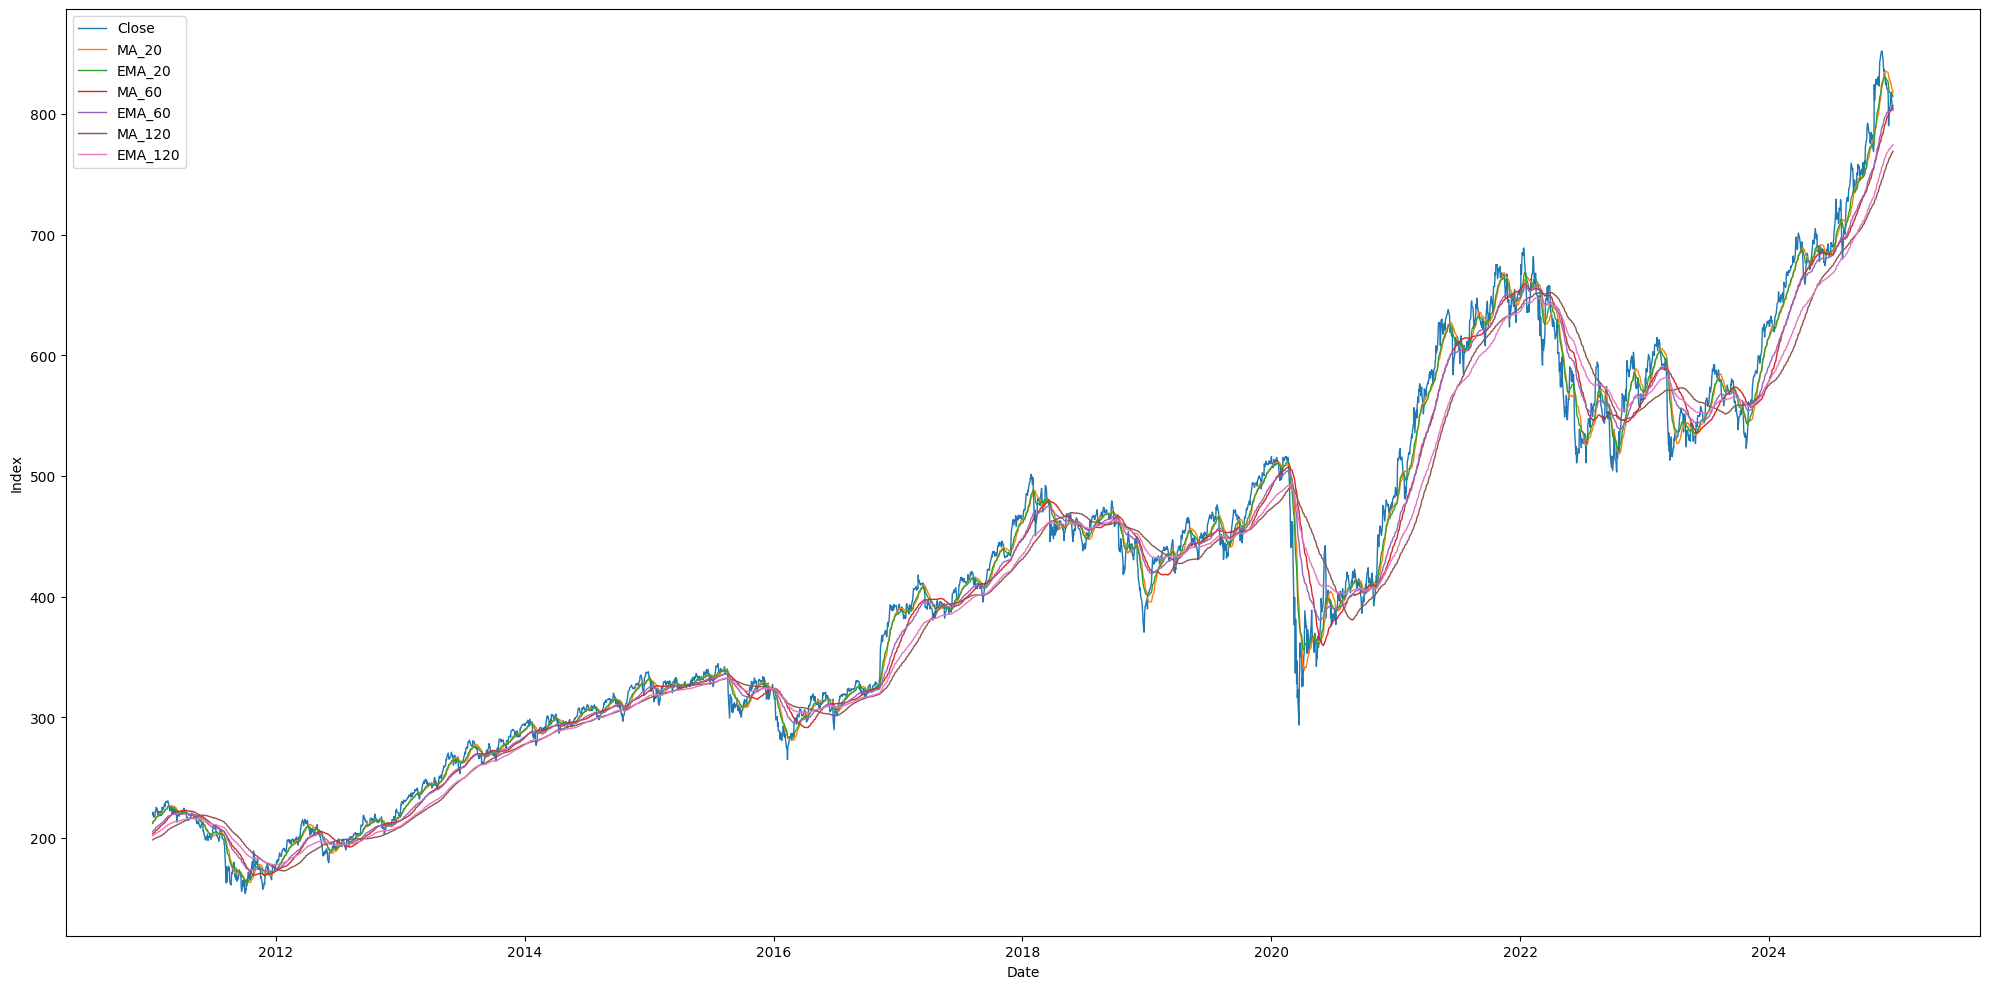

In [10]:
plt.figure(figsize=(20,10))

for col in ['Close', 'MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120']:
    plt.plot(data["Date"], data[col], label=f"{col}", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
line_path = os.path.join(FIG_DIR, "line_trend.png")
plt.savefig(line_path, dpi=150)
plt.close()

### 1.4.5. Heatmap

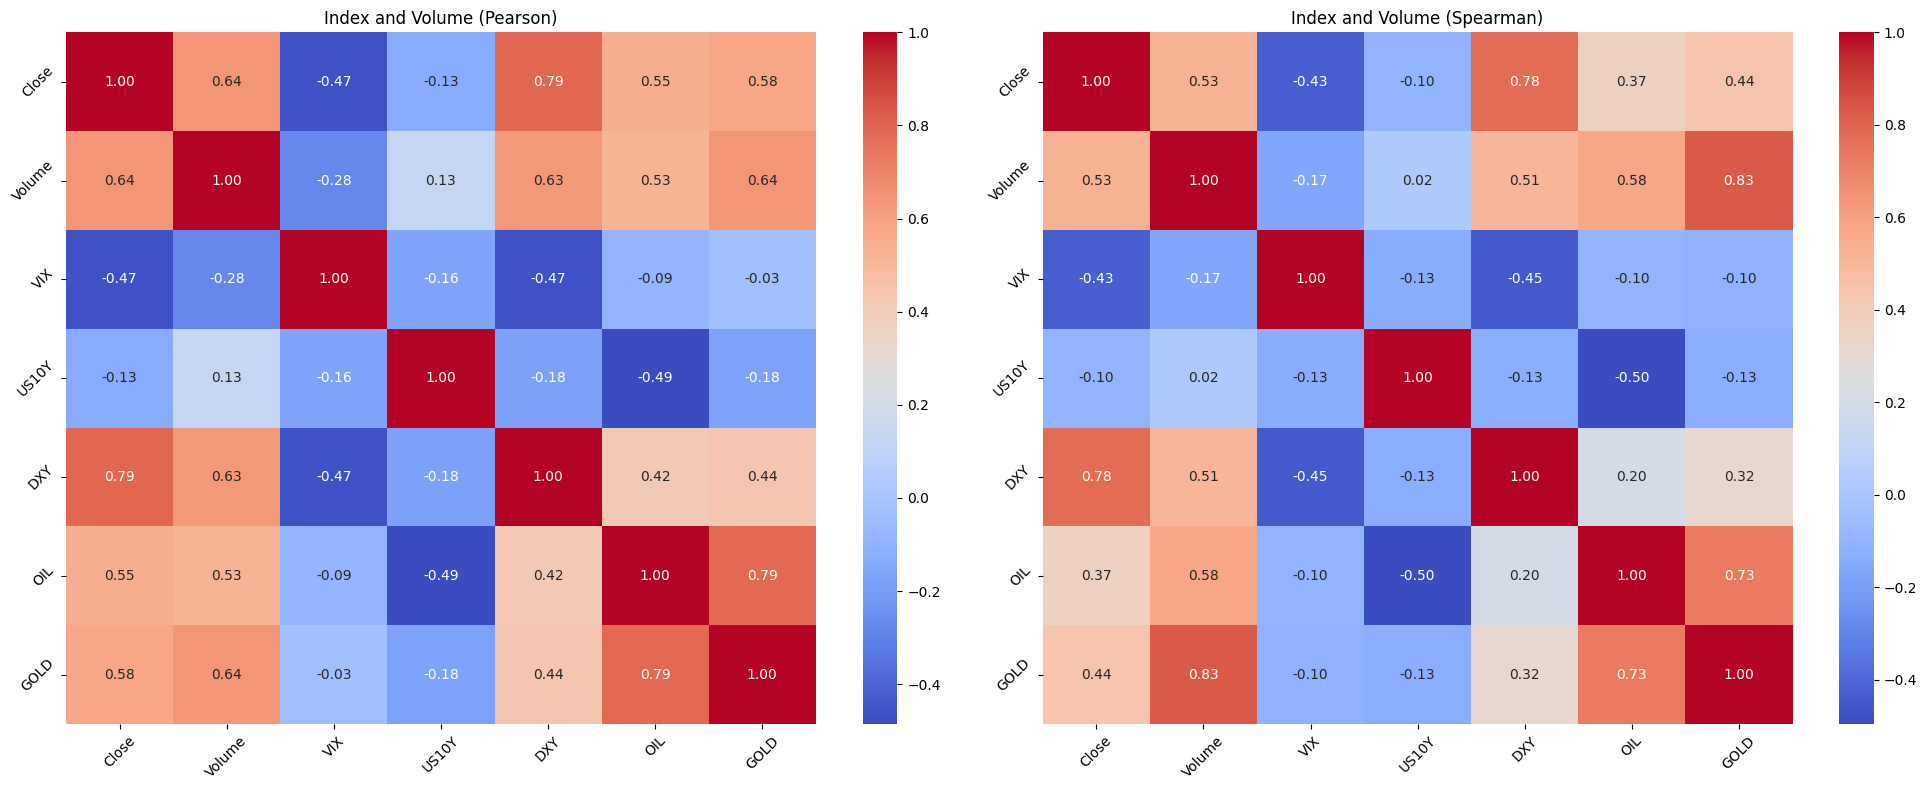

In [14]:
# corr_pear = data[[
#         'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD'
#     ]
# ].corr(method="pearson")

corr_pear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD'
    ]
].corr(method="pearson")

corr_spear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD'
    ]
].corr(method="spearman")

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Spearman)")

plt.tight_layout()
plt.show()

In [16]:
# X = data[[
#         'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD'
#     ]].dropna()

X = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD'
    ]].dropna()

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Feature         VIF
0   Close   28.165254
1  Volume    2.927142
2     VIX    4.561198
3   US10Y  129.095334
4     DXY  162.726435
5     OIL   12.132441
6    GOLD   88.050688


In [17]:
data.to_csv("data/v3.csv")

In [ ]:
# V1: ,Date,Open,High,Low,Close,Volume,GOLD,MA_20,EMA_20,MA_60,EMA_60,MA_120,EMA_120,MA_240,EMA_240,MAE_5,MAE_20,MAE_60,MAE_120,MACD,MACD_long,Signal,Signal_long,RSI,RSI_7,RSI_14,RSI_28
# V2: ,Date,Open,High,Low,Close,Volume,VIX,US10Y,DXY,OIL,GOLD,MA_20,EMA_20,MA_60,EMA_60,MA_120,EMA_120,MAE_5,MAE_20,MACD,MACD_long,Signal,Signal_long,RSI,RSI_7,RSI_14,RSI_28